In [109]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import subprocess

import random
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
from prettytable import PrettyTable

In [4]:
tqdm.pandas()

/Users/nathangupta/anaconda3/envs/e498/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Data Pre-processing

In [5]:
# GLOBAL PATH VARIABLE FOR AUDIO / TXT FILES:
path = 'respiratory-sound-database/audio_and_txt_files/'

In [6]:
def get_audio_files():
    folder = os.listdir(path)

    wav_files, txt_files = [], []
    for file in folder:
        if file.endswith('_16.wav'):
            wav_files.append(file)
        elif file.endswith('.txt'):
            txt_files.append(file)
    
    print("Sanity Check for Array Lengths: {}, {}".format(len(wav_files), len(txt_files)))
    return wav_files, txt_files

In [7]:
def extract_info(filename):
    splits = filename.split('_')
    print(splits)

In [8]:
# separate files by audio and txt
wav_files, txt_files = get_audio_files()
wav_files = sorted(wav_files)
txt_files = sorted(txt_files)

Sanity Check for Array Lengths: 920, 920


In [9]:
# extract information from the wav files' filename
# 0:[patient #], 1:[recording index], 2:[chest location], 3:[acquisition mode], 4:[recording equipment]
stripped_file_info = [re.sub('_16\.wav$', '', file) for file in wav_files]
file_info = [file.split('_') for file in stripped_file_info]

In [10]:
# load the extracted data into a dataframe
demog_data = pd.read_csv('demographic-info.csv')
diag_data = pd.read_csv('respiratory-sound-database/patient_diagnosis.csv', names=['Patient Number', 'Diagnosis'])
data = pd.DataFrame(data=file_info, 
                    columns=['Patient Number', 'Recording Index', 'Chest Location', 'Acquisition Mode', 'Recording Equipment'])

data['Patient Number'] = data['Patient Number'].astype(int)
data['txt_file'] = txt_files
data['audio_file'] = wav_files

In [11]:
# put info from demog_data into data
age, sex, a_BMI, c_weight, c_height, diagnosis = [], [], [], [], [], []
demog_size = demog_data['Age'].size
size = data['Patient Number'].size

In [12]:
# TODO: Make this more efficient
for j in range(0, size):
    for i in range(0, demog_size):
        if data['Patient Number'][j] == demog_data['Patient Number'][i]:
            age.append(demog_data['Age'][i])
            sex.append(demog_data['Sex'][i])
            a_BMI.append(demog_data['Adult BMI'][i])
            c_weight.append(demog_data['Child Weight'][i])
            c_height.append(demog_data['Child Height'][i])
        if data['Patient Number'][j] == diag_data['Patient Number'][i]:
            diagnosis.append(diag_data['Diagnosis'][i])
        pass

In [13]:
data['Age'], data['Sex'], data['Adult BMI'], data['Child Weight'], data['Child Height'], data['Diagnosis'] = age, sex, a_BMI, c_weight, c_height, diagnosis

In [14]:
# find the lowest sampling rate
lowest = np.inf

for f in data['audio_file']:
    sample_rate, samples = wavfile.read(path + f)
    if sample_rate < lowest:
        lowest = sample_rate

print(lowest)

4000


In [25]:
# function to get spectrogram from a wav file
def get_spectro(file_path):
    sample_rate, samples = wavfile.read(path + file_path)
    vector, freqs, bins, im = plt.specgram(samples[:], NFFT=1024, Fs=4000, noverlap=900)
    return vector

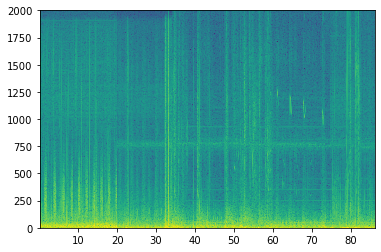

In [41]:
spec_vecs = []
sizes = []
for f in tqdm(data['audio_file']):
    spectrogram_vector = get_spectro(f)
    
    # Padding as per CNN bug
    # without padding, max size is (513, 2773)
    padded_spec_vec = np.zeros((513, 2773))
    padded_spec_vec[:spectrogram_vector.shape[0],:spectrogram_vector.shape[1]] = spectrogram_vector
    
    sizes.append(padded_spec_vec.shape)
    spec_vecs.append(padded_spec_vec)

In [43]:
# print(sizes)
print(max(sizes, key=lambda v: v[1]))
print(sizes.count((513, 2773)))

(513, 2773)
920


In [58]:
data['Spectrogram'] = spec_vecs
print(data.shape)
print(data.columns)
data.iloc[0].Spectrogram.shape

(920, 14)
Index(['Patient Number', 'Recording Index', 'Chest Location',
       'Acquisition Mode', 'Recording Equipment', 'txt_file', 'audio_file',
       'Age', 'Sex', 'Adult BMI', 'Child Weight', 'Child Height', 'Diagnosis',
       'Spectrogram'],
      dtype='object')


(513, 2773)

## CNN ##

In [61]:
# Split Indices
data_size = len(data)
test_per = 0.10
val_per = 0.10

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.1, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=0.25, random_state=1)

data_ind = np.arange(data_size)
random.shuffle(data_ind)
train_ind, val_ind, test_ind = np.split(data_ind, [int(1 - val_per*data_size-test_per*data_size), int(1-test_per*data_size)])

train_ind = sorted(train_ind)
val_ind = sorted(val_ind)
test_ind = sorted(test_ind)

print("Total Data Size: {}".format(data_size))
print("Train Size: {}".format(len(train_ind)))
print("Val Size: {}".format(len(test_ind)))
print("Test Size: {}".format(len(val_ind)))

Total Data Size: 920
Train Size: 737
Val Size: 91
Test Size: 92


In [126]:
# Split Data

x_cols = ['Spectrogram']
y_cols = ['Diagnosis']

x_train = data.iloc[train_ind, :]
# x_train = (x_train.loc[:, x_cols])
x_train = np.asarray(x_train['Spectrogram'].tolist())
x_val = data.iloc[val_ind, :]
# x_val = x_val.loc[:, x_cols]
x_val = np.asarray(x_val['Spectrogram'].tolist())
x_test = data.iloc[test_ind, :]
# x_test = x_test.loc[:, x_cols]
x_test = np.asarray(x_test['Spectrogram'].tolist())

y_train = data.iloc[train_ind, :]
# y_train = y_train.loc[:, y_cols]
y_train = np.asarray(y_train['Diagnosis'].tolist())
y_val = data.iloc[val_ind, :]
# y_val = y_val.loc[:, y_cols]
y_val = np.asarray(y_val['Diagnosis'].tolist())
y_test = data.iloc[test_ind, :]
# y_test = y_test.loc[:, y_cols]
y_test = np.asarray(y_test['Diagnosis'].tolist())

print("Sizes: \n Train x: {}, Train y: {}\n Val x: {}, Val y: {}\n Test x: {}, Test y: {}"
      .format(len(x_train), len(y_train), len(x_val), len(y_val), len(x_test), len(y_test)))

Sizes: 
 Train x: 737, Train y: 737
 Val x: 92, Val y: 92
 Test x: 91, Test y: 91


In [122]:
print(x_train[0].shape)
print(y_train[0])

# [print(vec[0].shape) for vec in x_train]
# print(x_train.shape)

# [print(vec[0].shape) for vec in x_val if vec[0].shape is None]

# [RESOLVED] FIXME: padding needed -- need to find largest dimension across train, val, test
# finding the max dimension
# dimen = [vec[0].shape[1] for d in [x_train, x_val, x_test] for vec in d]
# len(dimen)
# max(dimen)
# 2773, will use pad_to in specgram

# [RESOLVED] FIXME: need to flatten because right now it's a list of lists of lists
# print(x_train[0])
# print(x_train[0][0])
# np.fromiter((print(len(i)) for i in x_train), float)
# did this manually by first turning train/val/test into lists / not elegant

(513, 2773)
URTI


In [129]:
# Building Model

# reshape for the network

MAX_TIME = 513
MAX_FRQ = 2773
normalizer = 1

x_train = x_train.reshape(len(x_train), MAX_TIME, max_frq, 1) / normalizer
x_val = x_val.reshape(len(x_val), MAX_TIME, max_frq, 1) / normalizer
x_test = x_test.reshape(len(x_test), MAX_TIME, max_frq, 1) / normalizer

# create a linear stack of layers
# see: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
model = models.Sequential()

# first layer is a convolutional layer:
#   - 32 filters (or kernels)
#   - kernel width of 3x3
#   - relu (rectified linear unit) activation
#   - input shape (from the data)
#   - see for more options: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(MAX_TIME, MAX_FRQ, 1), name="layer1"))

# max pooling2
#   - argument describes how much to downsample the data (by a factor of 2 in both dimensions)
#   - see for more options: https://keras.io/layers/pooling/
model.add(layers.MaxPooling2D((2, 2), name="layer2"))

# convolution (same kernel size)
model.add(layers.Conv2D(64, (3,3), activation='relu', name="layer3"))

# max pooling
model.add(layers.MaxPooling2D((2, 2), name="layer4"))

# convolution layer
model.add(layers.Conv2D(64, (3,3), activation='relu', name="layer5"))

# flatten
model.add(layers.Flatten())

# dense
model.add(layers.Dense(64, activation='relu'))

# the final number of outputs (one for each class)
model.add(layers.Dense(8))

# compile the model
# using:
#   - the adam optimizer (see for more info: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)
#   - categorical cross entropy (also know as: softmax!)
#   - accuracy as the metric (FIXME)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [127]:
# CHECKING DATA TYPES AS PER TF ERROR

ls = [type(item) for item in x_train]
# print(ls)
d = {i:ls.count(i) for i in set(ls)}
print(d)

# y_train
ls = [type(item) for item in y_train]
# print(ls)
d = {i:ls.count(i) for i in set(ls)}
print(d)

# x_val
ls = [type(item) for item in x_val]
# print(ls)
d = {i:ls.count(i) for i in set(ls)}
print(d)

# y_val
ls = [type(item) for item in y_val]
# print(ls)
d = {i:ls.count(i) for i in set(ls)}
print(d)

print(data.info())

{<class 'numpy.ndarray'>: 737}
{<class 'numpy.str_'>: 737}
{<class 'numpy.ndarray'>: 92}
{<class 'numpy.str_'>: 92}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
Patient Number         920 non-null int64
Recording Index        920 non-null object
Chest Location         920 non-null object
Acquisition Mode       920 non-null object
Recording Equipment    920 non-null object
txt_file               920 non-null object
audio_file             920 non-null object
Age                    914 non-null float64
Sex                    914 non-null object
Adult BMI              840 non-null object
Child Weight           70 non-null object
Child Height           67 non-null float64
Diagnosis              920 non-null object
Spectrogram            920 non-null object
dtypes: float64(2), int64(1), object(11)
memory usage: 100.8+ KB
None


ValueError: Error when checking input: expected layer1_input to have 4 dimensions, but got array with shape (737, 513, 2773)

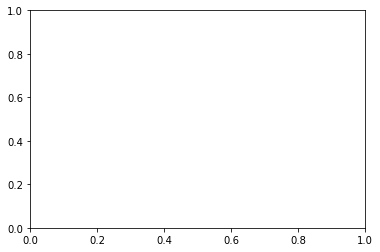

In [128]:
# Training Model
# how many epochs (passes through the data)
num_epochs = 10

# this will hold the performance
perf_time = np.zeros((num_epochs, 3))

# set up figure
fig = plt.figure()
ax1 = fig.add_subplot(111)

# training the network for num_epoch epochs
for epoch in tqdm(np.arange(0,num_epochs)):
    # train an epoch at a time, visualize as we go!
    model.fit(x_train, y_train, batch_size=128, epochs=1, verbose=2, validation_data=(x_val, y_val))
    
    # check the performance on train/test/val
    # the model.evaluate function returns the loss (position 0) and the performance (position 1)
    new_perf = [model.evaluate(x_train, y_train)[1], model.evaluate(x_val, y_val)[1], model.evaluate(x_test, y_test)[1]]
    
    # add to performance
    perf_time[epoch,:] = new_perf
    
    # visualize
    plt.plot(np.arange(0,epoch+1),perf_time[0:epoch+1,0],'b', label='train')
    plt.plot(np.arange(0,epoch+1),perf_time[0:epoch+1,1],'r', label='validation')
    plt.plot(np.arange(0,epoch+1),perf_time[0:epoch+1,2],'g', label='test')
    plt.legend(loc='upper left')
    plt.show()

perf_table = PrettyTable()
perf_table.field_names = ["Epoch", "Train Accuracy", "Val Accuracy", "Test Accuracy"]
for epoch in np.arange(0, num_epochs):
    perf_table.add_row(perf_time[epoch])